<a href="https://colab.research.google.com/github/Ashwin81456/emotion-classification-using-eeg-signals/blob/main/VISUALIZATIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the required libraries
import os
import time
import pickle
import pandas as pd
import numpy as np
from google.colab import drive

#for feature extraction
from scipy.signal import welch
from scipy.integrate import simps

#classifier libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb

from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [ ]:
def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [ ]:
#creating the file names of the dataset to load it
files = []
for n in range (1, 33):
    s = 's'
    if n < 10:
        s += '0'
    s += str(n)
    s+=str(".dat")
    files.append(s)
print(files)

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's06.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat', 's23.dat', 's24.dat', 's25.dat', 's26.dat', 's27.dat', 's28.dat', 's29.dat', 's30.dat', 's31.dat', 's32.dat']


In [ ]:
# 32x40 = 1280 trials for 32 participants
labels = []
data = []
drive.mount('/content/drive')
for i in files:
  filename = "/content/drive/My Drive/MajorProject/Dataset/" + i
  trial = read_data(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])


Mounted at /content/drive


In [ ]:
# Lets see the shapes of the raw data
labels = np.array(labels)
data = np.array(data)
print("Labels: ", labels.shape) # participants x videos x labels
print("Data: ", data.shape) # participants x videos x channels x data

Labels:  (32, 40, 4)
Data:  (32, 40, 40, 8064)


In [ ]:
# Re-shape arrays into desired shapes
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [ ]:
# Double-check the new arrays
#Here trial = participants x vidoes = 32 x 40 = 1280

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 40, 8064)


In [ ]:
#creating the dataframes for the labels
labelsDf = pd.DataFrame(labels)
print("printing the labels dataframe\n")
print(labelsDf)
print("\n\nDescribing the labels dataframe")
labelsDf.describe()

printing the labels dataframe

         0     1     2     3
0     7.71  7.60  6.90  7.83
1     8.10  7.31  7.28  8.47
2     8.58  7.54  9.00  7.08
3     4.94  6.01  6.12  8.06
4     6.96  3.92  7.19  6.05
...    ...   ...   ...   ...
1275  3.91  6.96  5.82  3.12
1276  2.81  6.13  6.06  1.04
1277  3.05  7.01  5.10  1.10
1278  3.99  7.17  4.85  1.00
1279  7.15  4.03  9.00  1.88

[1280 rows x 4 columns]


Describing the labels dataframe


,0,1,2,3
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,5.254313,5.156711,5.382750,5.518133
std,2.130816,2.020499,2.096321,2.282780
min,1.000000,1.000000,1.000000,1.000000
25%,3.867500,3.762500,3.932500,3.960000
50%,5.040000,5.230000,5.240000,6.050000
75%,7.050000,6.950000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [ ]:
#giving names to the label columns
df_labels= pd.DataFrame({'valence': labels[:,0], 'arousal': labels[:,1], 'dominance': labels[:,2], 'liking': labels[:,3]})
print(labelsDf.describe())


                 0            1            2            3
count  1280.000000  1280.000000  1280.000000  1280.000000
mean      5.254313     5.156711     5.382750     5.518133
std       2.130816     2.020499     2.096321     2.282780
min       1.000000     1.000000     1.000000     1.000000
25%       3.867500     3.762500     3.932500     3.960000
50%       5.040000     5.230000     5.240000     6.050000
75%       7.050000     6.950000     7.040000     7.090000
max       9.000000     9.000000     9.000000     9.000000


In [ ]:
#Dropping the Dominance and Liking columns
df_labels=df_labels.drop('dominance',axis=1)
df_labels=df_labels.drop('liking',axis=1)
# print(df_labels.describe())
print(df_labels)
# df = df.drop('B', axis=1)

      valence  arousal
0        7.71     7.60
1        8.10     7.31
2        8.58     7.54
3        4.94     6.01
4        6.96     3.92
...       ...      ...
1275     3.91     6.96
1276     2.81     6.13
1277     3.05     7.01
1278     3.99     7.17
1279     7.15     4.03

[1280 rows x 2 columns]


# Separte Valence and Arousal to HAHV, LAHV, HALV, LALV

In [ ]:
import numpy as np

# # Create a sample DataFrame with 'valence' and 'arousal' columns
# np.random.seed(0)
# valence = np.random.uniform(1, 9, 1280)
# arousal = np.random.uniform(1, 9, 1280)
# data = {'valence': valence, 'arousal': arousal}
# df_valence_arousal = pd.DataFrame(data)

# Calculate the median value of arousal and valence column
arousal_median = df_labels['arousal'].median()
print(arousal_median)
valence_median = df_labels['valence'].median()
print(valence_median)

# Create a new DataFrame with the desired columns
df_result = pd.DataFrame(index=range(1280), columns=['HAHV', 'LAHV', 'HALV', 'LALV'])
df_result[['HAHV', 'LAHV', 'HALV', 'LALV']] = 0

# Apply the conditions
df_result.loc[(df_labels['valence'] >= valence_median) & (df_labels['arousal'] >= arousal_median), 'HAHV'] = 1
df_result.loc[(df_labels['arousal'] < arousal_median) & (df_labels['valence'] >= valence_median), 'LAHV'] = 1
df_result.loc[(df_labels['arousal'] >= arousal_median) & (df_labels['valence'] < valence_median), 'HALV'] = 1
df_result.loc[(df_labels['valence'] < valence_median) & (df_labels['arousal'] < arousal_median), 'LALV'] = 1

# Show the first few rows of the result DataFrame
# df_result.tail()
print(df_result)


5.23
5.04
      HAHV  LAHV  HALV  LALV
0        1     0     0     0
1        1     0     0     0
2        1     0     0     0
3        0     0     1     0
4        0     1     0     0
...    ...   ...   ...   ...
1275     0     0     1     0
1276     0     0     1     0
1277     0     0     1     0
1278     0     0     1     0
1279     0     1     0     0

[1280 rows x 4 columns]


In [ ]:
# High Arousal Positive Valence dataset
df_hahv = df_labels[(df_labels['valence'] >= np.median(labels[:,0])) & (df_labels['arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_labels[(df_labels['valence'] >= np.median(labels[:,0])) & (df_labels['arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_labels[(df_labels['valence'] < np.median(labels[:,0])) & (df_labels['arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_labels[(df_labels['valence'] < np.median(labels[:,0])) & (df_labels['arousal'] < np.median(labels[:,1]))]

In [ ]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['valence'].mean(),2), "STD", np.round(df_hahv['valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['arousal'].mean(),2), "STD", np.round(df_hahv['arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['valence'].mean(),2), "STD", np.round(df_lahv['valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['arousal'].mean(),2), "STD", np.round(df_lahv['arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['valence'].mean(),2), "STD", np.round(df_halv['valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['arousal'].mean(),2), "STD", np.round(df_halv['arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['valence'].mean(),2), "STD", np.round(df_lalv['valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['arousal'].mean(),2), "STD", np.round(df_lalv['arousal'].std(),2))

HAHV
Valence: Mean 7.23 STD 1.03
Arousal: Mean 6.87 STD 0.87

LAHV:
Valence: Mean 6.59 STD 1.1
Arousal: Mean 3.83 STD 1.17

HALV:
Valence: Mean 3.11 STD 1.25
Arousal: Mean 6.8 STD 0.97

LALV:
Valence: Mean 3.59 STD 1.19
Arousal: Mean 3.12 STD 1.32


Verify the data in 4 classes

In [ ]:
# Check the number of 1s in each individual column
count_HAHV = df_result['HAHV'].sum()
count_LAHV = df_result['LAHV'].sum()
count_HALV = df_result['HALV'].sum()
count_LALV = df_result['LALV'].sum()

print(f"Number of 1s in HAHV: {count_HAHV}")
print(f"Number of 1s in LAHV: {count_LAHV}")
print(f"Number of 1s in HALV: {count_HALV}")
print(f"Number of 1s in LALV: {count_LALV}")

print(f"Total = {count_HAHV+count_LAHV+count_HALV+count_LALV}") # the total must be 1280


Number of 1s in HAHV: 358
Number of 1s in LAHV: 322
Number of 1s in HALV: 282
Number of 1s in LALV: 318
Total = 1280


{'whiskers': [<matplotlib.lines.Line2D at 0x7f316fa67040>,
 'caps': [<matplotlib.lines.Line2D at 0x7f316fa67580>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f316fa66da0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f316fa67ac0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f316fa67d60>,
 'means': []}

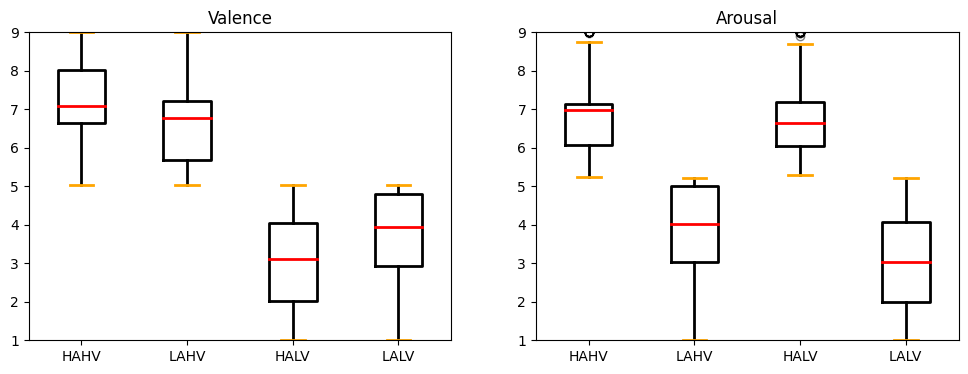

In [ ]:
#whisker plot of HAHV, LALV, HALV AND LAHV
# Valence and Arousal ratings between groups
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12,4))
boxprops = dict(linewidth=2, color='black')
whiskerprops = dict(linewidth=2, color='black')
capprops = dict(linewidth=2, color='orange')
medianprops = dict(linewidth=2, color='red')
flierprops = dict(marker='o', color='brown', alpha=0.5)

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['valence'], df_lahv['valence'], df_halv['valence'], df_lalv['valence']], labels=['HAHV','LAHV','HALV', 'LALV'],boxprops=boxprops,
               whiskerprops=whiskerprops,
               capprops=capprops,
               medianprops=medianprops,
               flierprops=flierprops)

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['arousal'], df_lahv['arousal'], df_halv['arousal'], df_lalv['arousal']], labels=['HAHV','LAHV','HALV', 'LALV'],boxprops=boxprops,
               whiskerprops=whiskerprops,
               capprops=capprops,
               medianprops=medianprops,
               flierprops=flierprops)

{'whiskers': [<matplotlib.lines.Line2D at 0x7e9aadb61a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7e9aada817b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e9aadb612a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7e9aada82860>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e9aada832e0>,
 'means': []}

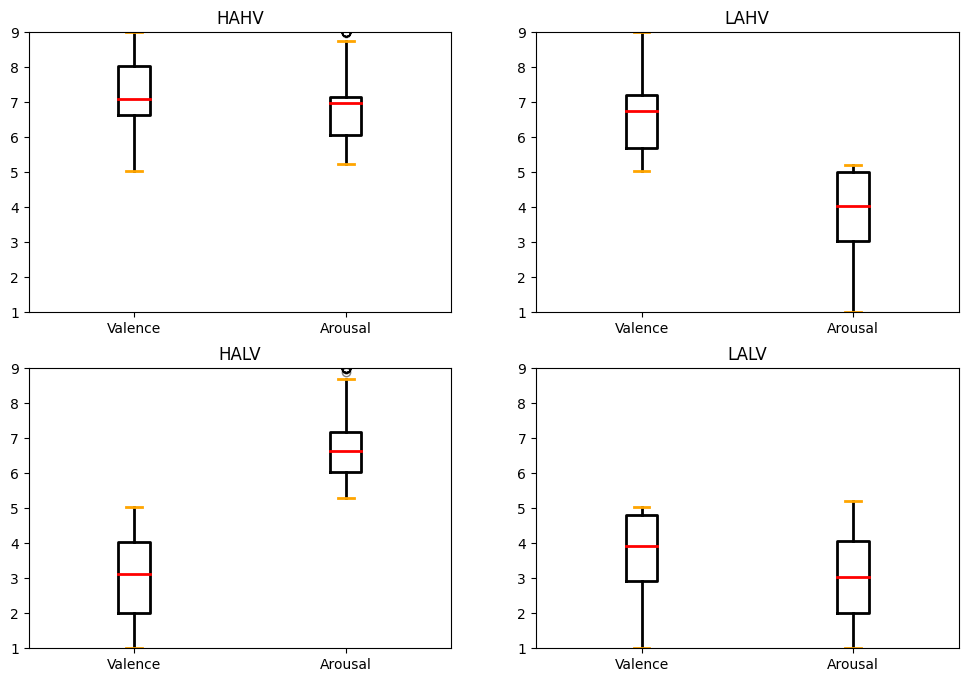

In [ ]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['valence'], df_hahv['arousal']], labels=['Valence','Arousal'],boxprops=boxprops,
               whiskerprops=whiskerprops,
               capprops=capprops,
               medianprops=medianprops,
               flierprops=flierprops)

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['valence'], df_lahv['arousal']], labels=['Valence','Arousal'],boxprops=boxprops,
               whiskerprops=whiskerprops,
               capprops=capprops,
               medianprops=medianprops,
               flierprops=flierprops)

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['valence'], df_halv['arousal']], labels=['Valence','Arousal'],boxprops=boxprops,
               whiskerprops=whiskerprops,
               capprops=capprops,
               medianprops=medianprops,
               flierprops=flierprops)

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['valence'], df_lalv['arousal']], labels=['Valence','Arousal'],boxprops=boxprops,
               whiskerprops=whiskerprops,
               capprops=capprops,
               medianprops=medianprops,
               flierprops=flierprops)

In [ ]:
# Dataset with only Valence column
df_val = df_labels['valence']
# Dataset with only Arousal column
df_aro = df_labels['arousal']

In [ ]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [ ]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
    labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (1280, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["High Valence", "High Arousal"])
print(df_labels.describe())
print(df_labels)

       High Valence  High Arousal
count   1280.000000   1280.000000
mean       0.531250      0.500000
std        0.499218      0.500195
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.000000      0.500000
75%        1.000000      1.000000
max        1.000000      1.000000
      High Valence  High Arousal
0                1             1
1                1             1
2                1             1
3                0             1
4                1             0
...            ...           ...
1275             0             1
1276             0             1
1277             0             1
1278             0             1
1279             1             0

[1280 rows x 2 columns]


In [ ]:
# Dataset with only Valence column
df_valence = df_labels['High Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']
print(df_valence)
print(df_valence.shape)

0       1
1       1
2       1
3       0
4       1
       ..
1275    0
1276    0
1277    0
1278    0
1279    1
Name: High Valence, Length: 1280, dtype: int64
(1280,)


# FEATURE EXTRACTION USING WELCH'S METHOD

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(1280, 32, 8064)


In [ ]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(1280, 8, 8064)


63.0


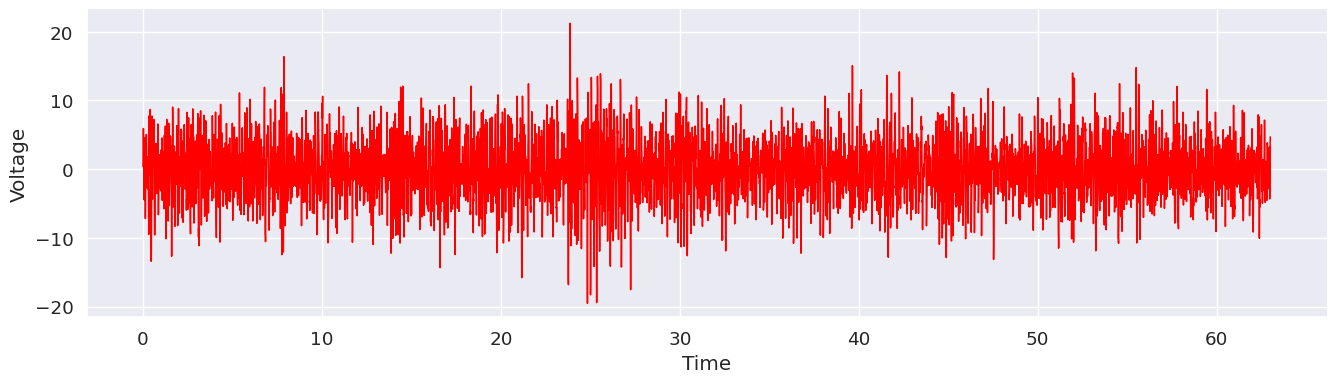

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
g_data=eeg_data[0,31]
print(g_data.size / sf)
time = np.arange(g_data.size) / sf

# Plot the signal of first trial, last channel
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(time,eeg_data[0,31], lw=1.1, color='red')
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

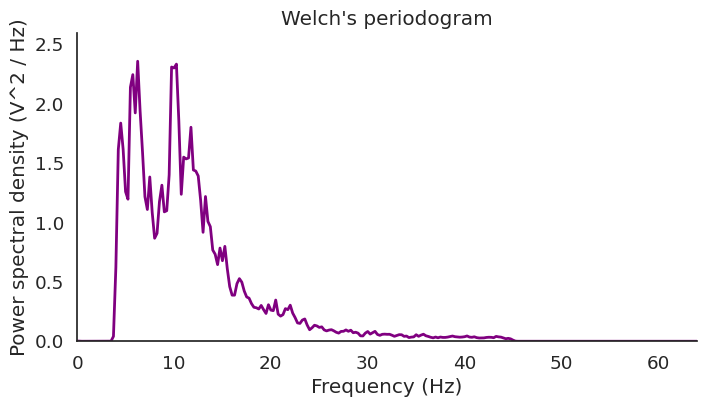

In [ ]:
from scipy import signal
from scipy.signal import welch

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='purple', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

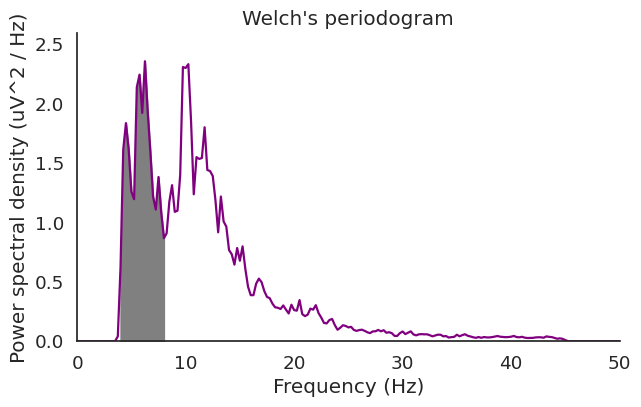

In [ ]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=1.6, color='purple')
plt.fill_between(freqs, psd, where=idx_theta, color='gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

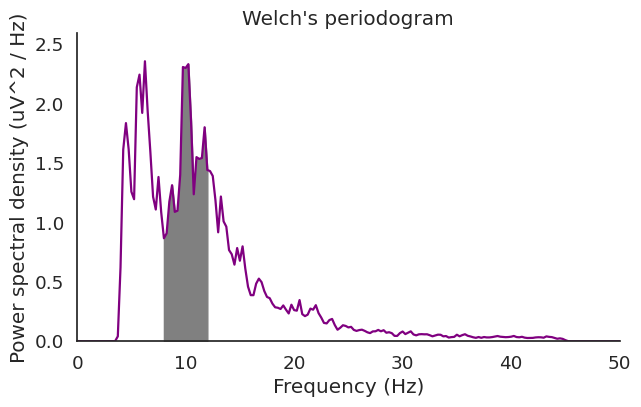

In [ ]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=1.6, color='purple')
plt.fill_between(freqs, psd, where=idx_alpha, color='gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

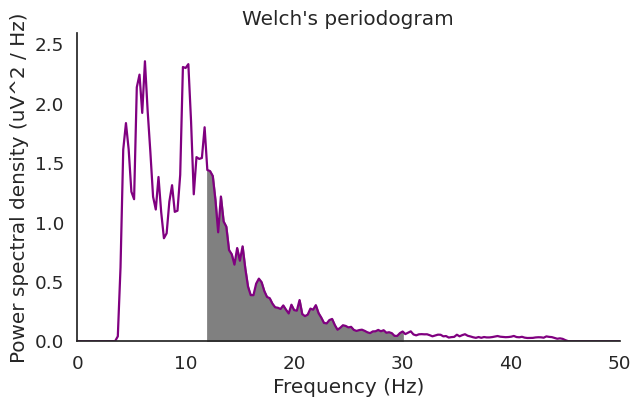

In [ ]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=1.6, color='purple')
plt.fill_between(freqs, psd, where=idx_beta, color='gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

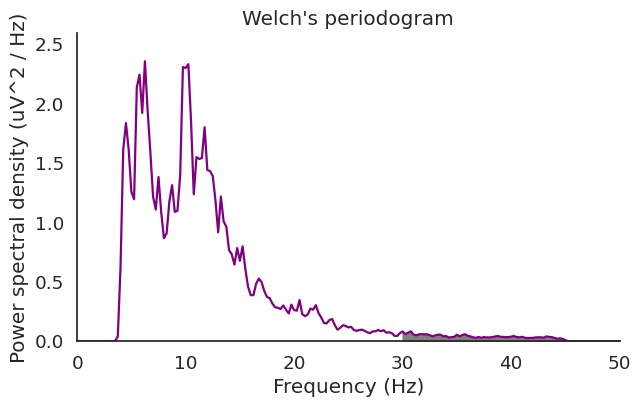

In [ ]:
# Define delta lower and upper limits
low, high = 30, 64

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=1.6, color='purple')
plt.fill_between(freqs, psd, where=idx_gamma, color='gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)

  return bandpower(eeg_data[trial,channel], 128, bd)


In [ ]:
print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
0.9879159580139809


#EEG Plots

In [ ]:
!pip install mne==0.22.0
import mne
info = mne.create_info(32, sfreq=128)
print(info)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 15.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
/usr/local/lib/python3.10/dist-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
raw_data = mne.io.RawArray(eeg_data[31], info)


Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Creating RawArray with float64 data, n_channels=32, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


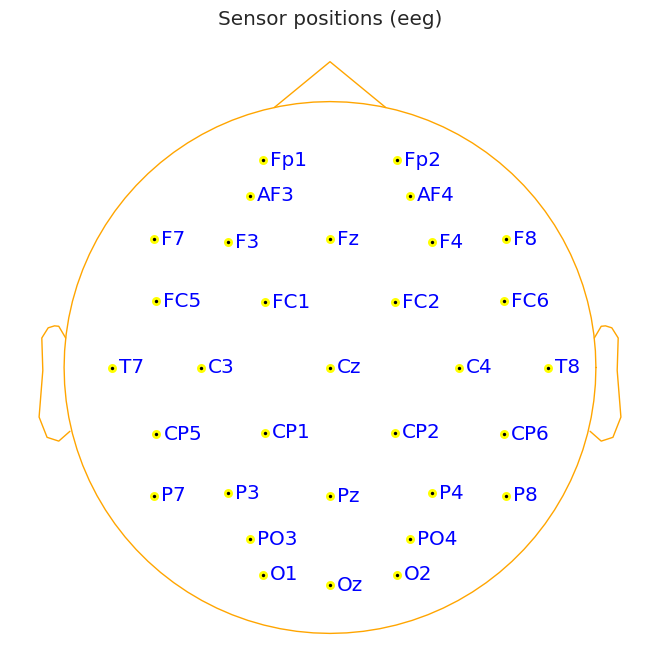

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Create and set the montage
montage = mne.channels.make_standard_montage("biosemi32")
info = mne.create_info(ch_names=montage.ch_names, sfreq=256., ch_types='eeg')
raw_data = mne.io.RawArray(np.random.randn(len(montage.ch_names), 1000), info)
raw_data.set_montage(montage)

# Plot the montage
fig = montage.plot(show=False)

# Modify the plot (dots color, line color, etc.)
ax = fig.gca()
for line in ax.lines:
    line.set_color('orange')  # Change the color of the lines connecting dots

for text in ax.texts:
    text.set_color('blue')  # Change the color of the text labels

for pathcollection in ax.collections:
    pathcollection.set_edgecolor('yellow')  # Change the color of the edges of the dots
    pathcollection.set_facecolor('black')   # Change the color of the faces of the dots

plt.show()


Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Effective window size : 16.000 (s)


TypeError: SpanSelector.__init__() got an unexpected keyword argument 'rectprops'

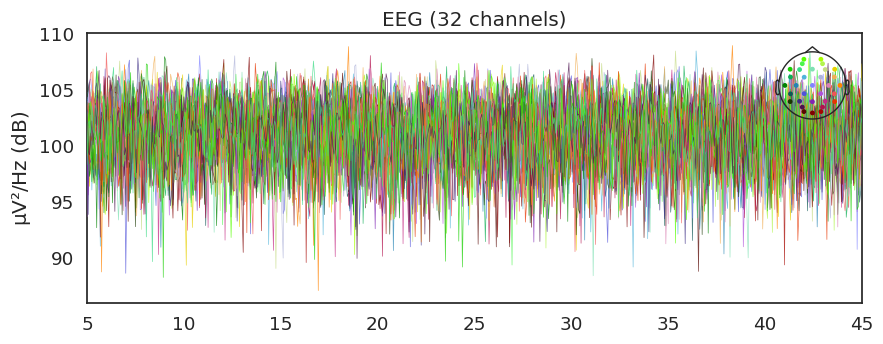

In [ ]:
# Create and set the montage
montage = mne.channels.make_standard_montage("biosemi32")
info = mne.create_info(ch_names=montage.ch_names, sfreq=128., ch_types='eeg')
raw_data = mne.io.RawArray(np.random.randn(len(montage.ch_names), 128 * 60), info)  # 1 minute of data
raw_data.set_montage(montage)

# Calculate n_fft for a window size of 16 seconds
window_size_seconds = 16
sfreq = 128
n_fft = int(sfreq * window_size_seconds)

# Plot the PSD
mne.viz.plot_raw_psd(raw_data, fmin=5, fmax=45, n_fft=n_fft)

Topographic Maps

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_freq = cast(l_freq)
/

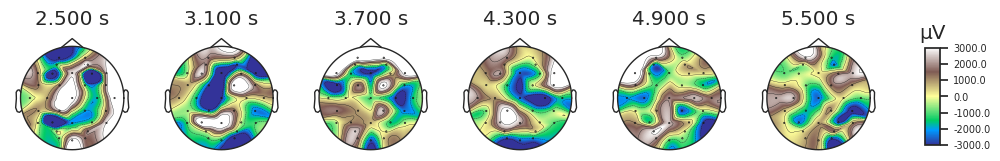

In [ ]:
import mne
import numpy as np

# Generate example EEG data (1 trial, 32 channels, 1000 samples)
n_channels = 32
n_samples = 1280  # Number of time points
sfreq = 128.0  # Sampling frequency in Hz
eeg_data = np.random.randn(1, n_channels, n_samples)

# Create MNE info structure with BioSemi 32-channel montage
montage = mne.channels.make_standard_montage("biosemi32")
info = mne.create_info(ch_names=montage.ch_names, sfreq=sfreq, ch_types='eeg')
info.set_montage(montage)

# Create EvokedArray for the first trial
evData_th = mne.EvokedArray(eeg_data[0], info)

# Filter the data to the theta band (4-8 Hz)
evData_th.filter(4, 8)

# Define the time points for the topomap
times = np.arange(2.5, 6,0.6)

# Plot the topomap with adjusted scale
evData_th.plot_topomap(times, ch_type='eeg', average=6, time_unit='s', cmap='terrain', vmin=-3000, vmax=3000)

# Show the plot
plt.show()


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_freq = cast(l_freq)
/

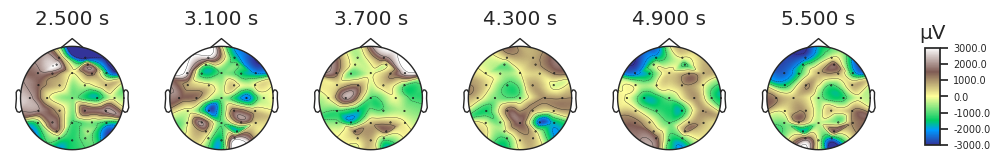

In [ ]:
import mne
import numpy as np

# Generate example EEG data (1 trial, 32 channels, 1000 samples)
n_channels = 32
n_samples = 1000  # Number of time points
sfreq = 128.0  # Sampling frequency in Hz
eeg_data = np.random.randn(1, n_channels, n_samples)

# Create MNE info structure with BioSemi 32-channel montage
montage = mne.channels.make_standard_montage("biosemi32")
info = mne.create_info(ch_names=montage.ch_names, sfreq=sfreq, ch_types='eeg')
info.set_montage(montage)

# Create EvokedArray for the first trial
evData_th = mne.EvokedArray(eeg_data[0], info)

# Filter the data to the theta band (4-8 Hz)
evData_th.filter(8,12)

# Define the time points for the topomap
times = np.arange(2.5, 6,0.6)

# Plot the topomap with adjusted scale
evData_th.plot_topomap(times, ch_type='eeg', average=6, time_unit='s', cmap='terrain', vmin=-3000, vmax=3000)

# Show the plot
plt.show()


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_freq = cast(l_freq)
/

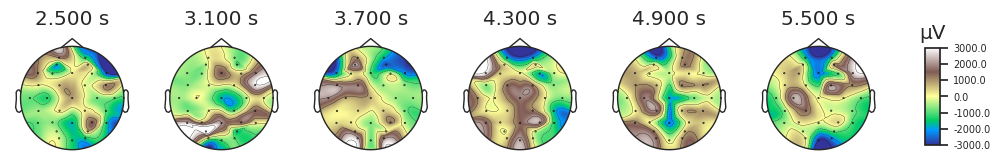

In [ ]:
import mne
import numpy as np

# Generate example EEG data (1 trial, 32 channels, 1000 samples)
n_channels = 32
n_samples = 1000  # Number of time points
sfreq = 128.0  # Sampling frequency in Hz
eeg_data = np.random.randn(1, n_channels, n_samples)

# Create MNE info structure with BioSemi 32-channel montage
montage = mne.channels.make_standard_montage("biosemi32")
info = mne.create_info(ch_names=montage.ch_names, sfreq=sfreq, ch_types='eeg')
info.set_montage(montage)

# Create EvokedArray for the first trial
evData_th = mne.EvokedArray(eeg_data[0], info)

# Filter the data to the theta band (4-8 Hz)
evData_th.filter(12,30)

# Define the time points for the topomap
times = np.arange(2.5, 6,0.6)

# Plot the topomap with adjusted scale
evData_th.plot_topomap(times, ch_type='eeg', average=6, time_unit='s', cmap='terrain', vmin=-3000, vmax=3000)

# Show the plot
plt.show()


Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/usr/local/lib/python3.10/dist-packages/mne/filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_freq = cast(l_freq)
/

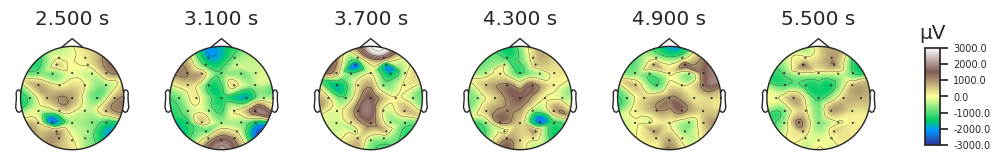

In [ ]:
import mne
import numpy as np

# Generate example EEG data (1 trial, 32 channels, 1000 samples)
n_channels = 32
n_samples = 1000  # Number of time points
sfreq = 128.0  # Sampling frequency in Hz
eeg_data = np.random.randn(1, n_channels, n_samples)

# Create MNE info structure with BioSemi 32-channel montage
montage = mne.channels.make_standard_montage("biosemi32")
info = mne.create_info(ch_names=montage.ch_names, sfreq=sfreq, ch_types='eeg')
info.set_montage(montage)

# Create EvokedArray for the first trial
evData_th = mne.EvokedArray(eeg_data[0], info)

# Filter the data to the theta band (4-8 Hz)
evData_th.filter(30,63.9)

# Define the time points for the topomap
times = np.arange(2.5, 6,0.6)

# Plot the topomap with adjusted scale
evData_th.plot_topomap(times, ch_type='eeg', average=6, time_unit='s', cmap='terrain', vmin=-3000, vmax=3000)

# Show the plot
plt.show()


# Process new datasets with 6 EEG regions and 4 band power values

In [ ]:
# Transform 1280x 32 x 8064 => 1280 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (1280, 128))

In [ ]:
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

In [ ]:
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (1280, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count   1280.000000   1280.000000   1280.000000   1280.000000   1280.000000   
mean     517.431002    974.493856    795.093910   1515.004071    746.435950   
std     1165.295163   3147.555132   3020.711666   4990.544508   2188.101734   
min        2.698928      1.995398      1.820656      3.283107      1.311200   
25%       23.306027     17.117475     18.392335     30.827191     14.023436   
50%       65.468048     82.102529     60.241953     91.266539     48.704968   
75%      331.636624    304.949248    175.394835    248.308696    218.358248   
max    15524.135098  38122.870846  39431.320394  49272.793208  20182.668545   

               FC1            C3           T7           CP5          CP1  ...  \
count  1280.000000   1280.000000  1280.000000   1280.000000  1280.000000  ...   
mean    345.936665    486.095113   354.004358    664.656754   276.667812  ...   
std     717.328768   1497.636647   641.432373

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (1280, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

               Fp1           AF3            F3            F7          FC5  \
count  1280.000000   1280.000000   1280.000000   1280.000000  1280.000000   
mean    173.544174    333.184883    285.545436    573.725974   249.793720   
std     378.371554   1058.758333   1036.330438   1943.692827   702.436934   
min       2.770151      1.793012      1.724442      2.793554     0.975527   
25%      14.082681     10.737435     10.012318     15.888935    10.074042   
50%      33.713172     34.992442     30.026795     38.178299    20.079100   
75%     125.508396    114.334883     73.488279     93.987498    74.040939   
max    5627.906982  12380.702125  12764.724842  20843.070851  6575.781434   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean    138.011594   170.423962   124.101183   232.750895    97.610644  ...   
std     275.218934   497.507620   200.171342   735.717912   166.43002

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (1280, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

               Fp1          AF3           F3            F7          FC5  \
count  1280.000000  1280.000000  1280.000000   1280.000000  1280.000000   
mean     92.200266   200.684361   193.372441    341.951096   140.642394   
std     176.162562   668.027842   668.771074   1274.679748   386.740178   
min       4.486703     2.650970     2.784376      3.363422     2.788531   
25%      17.999409    13.190613    10.170223     17.951892    11.341571   
50%      34.413828    29.155242    28.120517     33.617573    22.402198   
75%      80.774739   107.619088    59.807546     62.087123    53.162211   
max    3528.485435  5784.160193  5841.475721  14848.700463  3094.687504   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean     99.397187    96.901859    77.540922   137.387625    55.047411  ...   
std     197.556641   247.621839    90.107877   409.366974    85.846400  ...   
min     

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (1280, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

               Fp1          AF3           F3           F7          FC5  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000   
mean     50.663247   150.492372   149.210824   122.775294    91.633571   
std     135.591365   645.635199   632.049548   496.744509   340.562025   
min       1.069233     1.119910     0.791859     1.177512     0.712624   
25%       8.292302     5.605668     4.352724     7.591098     5.172920   
50%      18.329100    14.069330    11.828027    15.919877    12.648067   
75%      39.995543    43.454610    28.586812    36.456420    38.094737   
max    3213.255538  6060.539788  5758.756812  6348.177208  3472.515858   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean     60.487715    56.236468    43.792285    77.048369    29.250057  ...   
std     139.230040   180.285647    62.089299   267.809883    68.503827  ...   
min       0.69492

In [ ]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
  return x_train, x_test, y_train, y_test

In [ ]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

In [ ]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["frontal",  "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [ ]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'rbf',random_state = 42, probability=True)

In [ ]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [ ]:
clf_dtree=DecisionTreeClassifier(max_depth=20,min_samples_split=4)

In [ ]:
clf_rf=RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)

In [ ]:
clf_nb= GaussianNB()

In [ ]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [ ]:
clf_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)


In [ ]:
clf_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)


In [ ]:
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier()

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
clf_gpc = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), random_state=42)


In [ ]:
from sklearn.linear_model import Perceptron
clf_perceptron = Perceptron(random_state=42)

In [ ]:
!pip install catboost
import catboost as cb
clf_catboost = cb.CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
#define cnn model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

def create_cnn_model(data_np):
    model = Sequential([
        Input(shape=(data_np.shape[1], 1)),  # Adjusted to match data_np shape
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(2, activation='softmax')
    ])
    return model

def train_and_evaluate_cnn(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Reshape data for CNN: (number of samples, height, width, channels)
    # Here, height=1, width=number of features, channels=1
    data_reshaped = data_np.reshape((data_np.shape[0], data_np.shape[1], 1))

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels_encoded, test_size=0.20, random_state=42)

    # Define the CNN model
    model = create_cnn_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    return test_loss, test_accuracy


In [ ]:
#define ann model
def create_ann_model(data_scaled):
    model = Sequential([
        Dense(64, input_dim=data_scaled.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')  # Assuming two classes: 0 and 1
    ])
    return model


def train_and_evaluate_ann(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_np)

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels_encoded, test_size=0.2, random_state=42)

    # Define the CNN model
    model = create_ann_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    return test_loss, test_accuracy

In [ ]:
#define lstm model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def create_lstm_model(data_np):
    model = Sequential([
    LSTM(20, input_shape=(data_np.shape[1], 1)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Assuming two classes: 0 and 1
    ])
    return model

def train_and_evaluate_lstm(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Reshape data for LSTM: (samples, time_steps, features)
    # Here, each row is treated as a sequence with a single time step
    data_reshaped = data_np.reshape((data_np.shape[0], data_np.shape[1], 1))

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels_encoded, test_size=0.2, random_state=42)
    # Define the CNN model
    model = create_lstm_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    return test_loss, test_accuracy




In [ ]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('DT', clf_dtree))
models.append(('RF', clf_rf))
models.append(('NB', clf_nb))
models.append(('MLP', clf_mlp))
models.append(('AB', clf_adaboost))
models.append(('XGB', clf_xgb))

In [ ]:
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  elif (band == "beta"):
    df_x = df_beta
  elif (band == "gamma"):
    df_x = df_gamma

  if (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  # df_y = df_arousal if (label == "arousal") else df_valence
  # print(df_y.shape)
  # df_y = df_result["HAHV"]
  # df_y = df_result
  # df_y = df_y.flatten
  # print(f"the shape of df_y is {df_y.shape}")
  # print(f"the shape of df_x is {df_x.shape}")
  if (label == "HAHV"):
    df_y = df_result["HAHV"]
  elif (label == "LAHV"):
    df_y = df_result["LAHV"]
  elif (label == "HALV"):
    df_y = df_result["HALV"]
  elif (label == "LALV"):
    df_y = df_result["LALV"]

  # print(f"the shape of df_y is {df_y.shape}")
  # print(f"the shape of df_x is {df_x.shape}")
  # Train-test split

  # save he dataframes in csv format for analysis
  # if (band == "gamma" and channel == "frontal" and label == "HALV"):
  #   df_y.to_csv('labels.csv', index=False)
  #   print("DataFrame saved to 'labels.csv'")
  #   df_x.to_csv('data.csv', index=False)
  #   print("DataFrame saved to 'data.csv'")
  #   from google.colab import files
  #   files.download('labels.csv')
  #   files.download('data.csv')

  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)

  # Apply CV
  x_for_kfold = np.array(x_train)
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]

  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  # Feature scaling
  # scaler = StandardScaler()
  # x_train2 = scaler.fit_transform(x_train2)
  # x_test2 = scaler.transform(x_test2)


  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif (clf == "dtree"):
    clf_dtree.fit(x_train2, y_train2)
    y_predict = clf_dtree.predict(x_test2)
  elif (clf == "rf"):
    clf_rf.fit(x_train2, y_train2)
    y_predict = clf_rf.predict(x_test2)
  elif (clf == "nb"):
    clf_nb.fit(x_train2, y_train2)
    y_predict = clf_nb.predict(x_test2)
  elif (clf == "mlp"):
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)
  elif (clf == "ab"):
    clf_adaboost.fit(x_train2, y_train2)
    y_predict = clf_adaboost.predict(x_test2)
  elif (clf == "xgb"):
    clf_xgb.fit(x_train2, y_train2)
    y_predict = clf_xgb.predict(x_test2)
  elif (clf == "lgbm"):
    clf_lgbm.fit(x_train2, y_train2)
    y_predict = clf_lgbm.predict(x_test2)
  elif (clf == "gpc"):
    clf_gpc.fit(x_train2, y_train2)
    y_predict = clf_gpc.predict(x_test2)
  elif (clf == "per"):
    clf_perceptron.fit(x_train2, y_train2)
    y_predict = clf_perceptron.predict(x_test2)
  elif (clf == "cb"):
    clf_catboost.fit(x_train2, y_train2)
    y_predict = clf_catboost.predict(x_test2)
  elif (clf == "cnn"):
    # Evaluate the model on the test set
    test_loss, test_accuracy = train_and_evaluate_cnn(df_x, df_y)
    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    return "DL",test_loss, test_accuracy

  elif(clf =="ann"):
    test_loss, test_accuracy = train_and_evaluate_ann(df_x, df_y)
    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    return "DL",test_loss, test_accuracy
  elif(clf =="lstm"):
    test_loss, test_accuracy = train_and_evaluate_lstm(df_x, df_y)
    return "DL",test_loss,test_accuracy
  return "ML",y_test2, y_predict

In [ ]:
def get_accuracy(band, channel, label, clf):
  classifier,y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  if (classifier == "DL"):
    return y_predict
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def print_conf(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  conf_matrix = confusion_matrix(y_test2, y_predict)
  # print(conf_matrix)
  plt.figure(figsize=(4, 2))  # Decrease the figure size
  plt.title('Confusion Matrix')
  sns.heatmap(conf_matrix,
              annot=True,
              fmt='g',
              xticklabels=['Not Spam','Spam'],
              yticklabels=['Not Spam','Spam'])

  # display matrix
  plt.ylabel('Actual',fontsize=12)
  plt.xlabel('Prediction',fontsize=12)
  plt.show()

  # printing the classification report aswell

  class_report = classification_report(y_test2, y_predict, target_names=['Not Spam', 'Spam'])
  print("\nClassification Report:")
  print(class_report)

In [ ]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)):
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,4))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  #print("Top 3 EEG regions with highest scores")
  #print(df.apply(lambda s: s.abs()).max().nlargest(3))
  #print()
  #print("Top 2 bands with highest scores")
  #print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  #print()
  #print("EEG region with highest scores per each band")
  #print(df.idxmax(axis=1))
  #print()
  #print("Accuracy Scores")
  #print(df.idxmax())
  #print()
  print(df)

In [ ]:
print_accuracy('HAHV', 'svm')

       frontal  central  parietal  occipital
theta    68.63    69.61     69.12      68.63
alpha    68.63    70.10     69.12      68.63
beta     70.10    69.61     70.10      70.10
gamma    69.61    69.61     70.10      69.61


In [ ]:
print_conf("beta","frontal","HAHV","svm")

In [ ]:
print_accuracy('LAHV', 'svm')

In [ ]:
print_conf("theta","occipital","LAHV","svm")

In [ ]:
print_accuracy('HALV', 'svm')

In [ ]:
print_conf("gamma","frontal","HALV","svm")

In [ ]:
print_accuracy('LALV', 'svm')

In [ ]:
print_conf("gamma","occipital","LALV","svm")

In [ ]:
print_accuracy("LALV","ann")

In [ ]:
print_accuracy("HALV","lstm")

Epoch 1/50
32/32 [==============================] - 9s 67ms/step - loss: 0.6641 - accuracy: 0.6357 - val_loss: 0.5201 - val_accuracy: 0.7930
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5913 - accuracy: 0.7529 - val_loss: 0.5151 - val_accuracy: 0.7930
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5653 - accuracy: 0.7559 - val_loss: 0.5125 - val_accuracy: 0.7930
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5797 - accuracy: 0.7656 - val_loss: 0.5179 - val_accuracy: 0.7930
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5664 - accuracy: 0.7686 - val_loss: 0.5146 - val_accuracy: 0.7930
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5568 - accuracy: 0.7705 - val_loss: 0.5167 - val_accuracy: 0.7930
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5572 - accuracy: 0.7725 - val_loss: 0.5144 - val_accuracy: 0.7930
Epoch 8/50
32/32 [=

In [ ]:
# print the confusion matrix which gives the highest accuracy
print_conf("theta","parietal","arousal","svm")

In [ ]:
print_accuracy('valence', 'svm')

In [ ]:
print_conf("gamma","central","valence","svm")

In [ ]:
print_accuracy('HAHV', 'ab')

In [ ]:
print_conf("gamma","occipital","arousal","ab")

In [ ]:
print_accuracy('valence', 'ab')

In [ ]:
print_accuracy('HAHV', 'xgb')

In [ ]:
print_accuracy('valence', 'xgb')

In [ ]:
print_conf("beta","central","valence","xgb")

In [ ]:
print_accuracy('HAHV', 'knn')

In [ ]:
print_accuracy('LALV', 'knn')

In [ ]:
print_accuracy('HALV', 'knn')

In [ ]:
print_accuracy('LAHV', 'knn')

In [ ]:
print_accuracy('HAHV', 'dtree')

In [ ]:
print_accuracy('LALV', 'dtree')

In [ ]:
print_accuracy('HAHV', 'rf')

In [ ]:
print_accuracy('LAHV', 'rf')

In [ ]:
print_accuracy('HALV', 'rf')

In [ ]:
print_accuracy('LALV', 'rf')

In [ ]:
print_accuracy('HAHV', 'cnn')

In [ ]:
print_accuracy('HALV', 'cnn')

In [ ]:
#

In [ ]:
# print_conf("gamma","frontal","arousal","cb")

In [ ]:
print_accuracy('HAHV', 'cb')